In [1]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np

In [226]:
def find_root(k,proper_labels):
    counter = 0
    while(proper_labels[k] != k and counter < len(proper_labels)):
        k = proper_labels[k]
        counter = counter + 1
    return k

def init_site_labels(rows,cols):
    proper_labels  = {-1:0,0:0}
    cluster_labels = {}
    for i in range(rows):
        for j in range(cols):
            cluster_labels[i*cols + j] = -1
    return cluster_labels, proper_labels  



def hoshen_kopleman(lattice):
    largest_label = 1
    rows, cols    = lattice.shape

    cluster_labels, proper_labels = init_site_labels(rows,cols)

    #forward sweep
    for i in range(rows):
        for j in range(cols):
            curr = lattice[i,j]
            if curr != 0:  #current cell occupied - only do the work if so
                up_index          = max(0,i-1)
                left_index        = max(0,j-1)
                up_linear_index   = up_index*cols + j     if i != 0 else 0
                left_linear_index = i*cols + left_index   if j != 0 else 0
                curr_linear_index = i*cols + j
                up                = lattice[up_index,j]   if i != 0 else 0
                left              = lattice[i,left_index] if j != 0 else 0
                if up == 0 and left == 0: #site is an island (so far)
                    proper_labels[largest_label]      = largest_label
                    cluster_labels[curr_linear_index] = largest_label
                    largest_label       += 1
                if up != 0 and left == 0: #site linked to the one above
                    cluster_labels[curr_linear_index] = cluster_labels[up_linear_index]
                if up == 0 and left != 0: #site linked to the one to the left
                    cluster_labels[curr_linear_index] = cluster_labels[left_linear_index]
                if up != 0 and left != 0: #site is a linker
                    cluster_label                     = min(cluster_labels[up_linear_index],cluster_labels[left_linear_index])
                    up_proper_label                   = proper_labels[cluster_labels[up_linear_index]]
                    left_proper_label                 = proper_labels[cluster_labels[left_linear_index]]
                    cluster_labels[curr_linear_index] = cluster_label
                    if up_proper_label > left_proper_label:
                        proper_labels[cluster_labels[up_linear_index]]   = proper_labels[cluster_labels[left_linear_index]]
                    else:
                        proper_labels[cluster_labels[left_linear_index]] = proper_labels[cluster_labels[up_linear_index]]

    #collapse the proper labels so that there is only one hop to the top of the tree
    collapsed_proper_labels = {}
    for k in proper_labels:
        collapsed_proper_labels[k] = find_root(k,proper_labels)

    return cluster_labels, collapsed_proper_labels

In [276]:
def analyze_for_spanners(mat):
    cluster_labels, proper_labels = hoshen_kopleman(mat)
    set_unique_cluster_labels = set(proper_labels.values())
    num_unique_clusters       = len(set_unique_cluster_labels)
    translate = {}
    for i,k in enumerate(set_unique_cluster_labels):
        translate[k] = i

    Cs = np.zeros(L*L,dtype=int)

    for i,k in enumerate(cluster_labels): 
        Cs[i] = translate[proper_labels[cluster_labels[k]]]
    Cs = Cs.reshape(L,L)    
    
    spanner = 0
    for s in range(1,np.max(Cs)+1):
        cluster_spots = np.where(Cs==s)
        rows = cluster_spots[0]
        cols = cluster_spots[1]
        row_span = max(rows) - min(rows)
        col_span = max(cols) - min(cols)
        if row_span == L - 1 or col_span == L - 1:
            spanner = 1
            
    return spanner

Text(0.5, 1.05, 'Probability p = 0.50\n 2 spanning clusters')

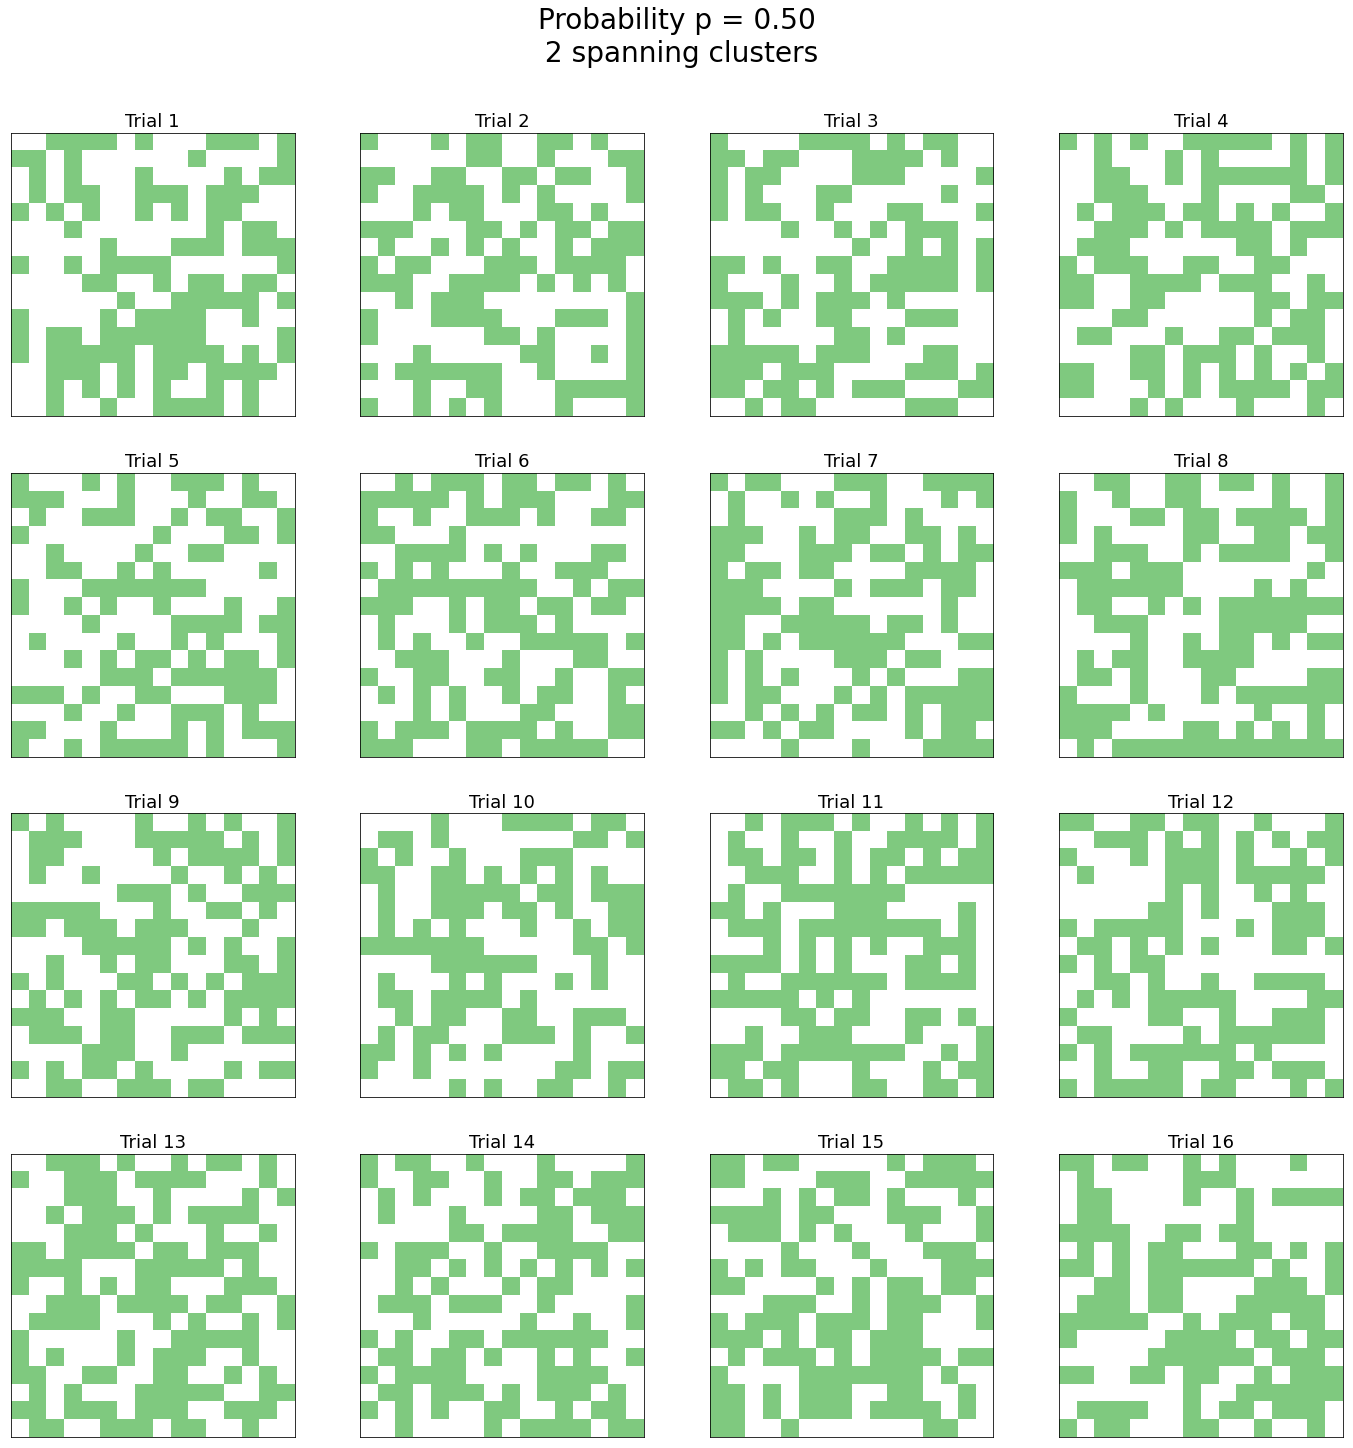

In [420]:
#get the physical and trial parameters 
p_init     = 0.5
L          = 16
nrows      = 4
ncols      = 4
num_spans  = 0

#allocate the figure
fig  = plt.figure(figsize=(24,24))
axes = []
cmap = mpl.cm.Accent  # Can be any colormap that you want after the cm
for i in range(nrows):
    for j in range(ncols):
        index      = ncols*i + j + 1
        temp_ax    = fig.add_subplot(nrows,ncols,index,aspect='equal')
        mat        = np.zeros((L,L))
        probs      = np.random.rand(L,L)
        trues      = np.where(probs <= p_init)
        mat[trues] = 1
        mask       = np.ma.masked_where(mat == 0, mat)
        temp_ax.imshow(mask, cmap=cmap)
        temp_ax.set_title('Trial %s' % index,fontsize=18)
        temp_ax.get_xaxis().set_visible(False)
        temp_ax.get_yaxis().set_visible(False)
        spanner = analyze_for_spanners(mat)
        #print(index,spanner)
        if spanner == 1:
            num_spans += 1
big_ax = fig.add_subplot(1,1,1)
big_ax.set_axis_off()
#big_ax.set_title(f'Probability p = {p_init:.2f}\n spanning cluster: {num_spans == 1}',y=1.05,fontsize=28)
big_ax.set_title(f'Probability p = {p_init:.2f}\n {num_spans} spanning clusters',y=1.05,fontsize=28)

In [417]:
#experimental data taken at about 2pm on 1/14/2024
pval      = np.array([0.1,0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.65,0.7])
nspansL4  = np.array([0,0,1,2,6,8,8,10,13,14])
nspansL8  = np.array([0,0,1,1,4,2,5,11,12,16])
nspansL16 = np.array([0,0,0,0,0,3,7,13,14,16])
nspansL32 = np.array([0,0,0,0,0,0,2,14,15,16])
nspansL64 = np.array([0,0,0,0,0,0,1,12,16,16])

Text(0, 0.5, 'Estimated Probability \n of a Spanning Cluster')

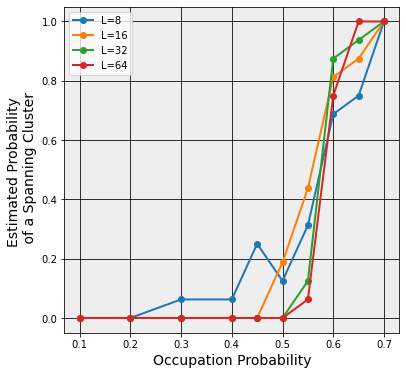

In [424]:
fig_L = plt.figure(figsize=(6,6))
ax_L  = fig_L.add_subplot(1,1,1)
#ax_L.plot(pval,nspansL4, label='L=4', linewidth=2,marker='.')
ax_L.plot(pval,nspansL8/16, label='L=8', linewidth=2,marker='o')
ax_L.plot(pval,nspansL16/16,label='L=16',linewidth=2,marker='o')
ax_L.plot(pval,nspansL32/16,label='L=32',linewidth=2,marker='o')
ax_L.plot(pval,nspansL64/16,label='L=64',linewidth=2,marker='o')
ax_L.set_facecolor('#eeeeee')
ax_L.grid('on',color='k')
ax_L.legend()
ax_L.set_xlabel('Occupation Probability',fontsize=14)
ax_L.set_ylabel('Estimated Probability \n of a Spanning Cluster',fontsize=14)

In [425]:
fig_L.savefig('Percolation_results_as_a_function_of_L.png')

In [418]:
fig.savefig(f'Percolation_trials_L{L}_prob_{p_init:.3f}.png')

In [399]:
pwd

'C:\\Users\\byecs\\OneDrive\\Python'